In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Precision, Recall

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc

In [2]:
# setup and freeze the base model top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the layers

58889256/58889256 [==============================] - 7s 0us/step


In [4]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [41]:
# create top layer for transfer model
trans_vgg16 = Sequential()
trans_vgg16.add(base_model)
trans_vgg16.add(Flatten())
trans_vgg16.add(Dense(1, activation='sigmoid'))

# compile
trans_vgg16.compile(optimizer='adam', loss='bce', metrics=['accuracy', 'AUC', Precision(), Recall()])

# architecture
trans_vgg16.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 1)                 25089     
                                                                 
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [42]:
# create the image data generator to apply to the transformations to data
# the transformations are realistic as it relates to what could be seen
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    brightness_range=(0.8, 1.2),
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
)

validate_datagen = ImageDataGenerator(
    rescale = 1./255
)

# Loading in image data
model_target_size = (224, 224)
model_batch_size = 32

train_generator = train_datagen.flow_from_directory(
    '../data/train/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

validation_generator = validate_datagen.flow_from_directory(
    '../data/validate/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode='binary',
    shuffle=True,
    seed=27,
)

Found 1040 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [21]:
# add callbacks
checkpoint_path='../assets/saved_models/vgg16_models/'
checkpoint_vgg16 = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1, save_weights_only=False)
earlystopping_vgg16 = EarlyStopping(restore_best_weights=True, monitor='val_accuracy', min_delta=0, patience=15, verbose=1, mode='auto')

# fit model
history_trans_vgg16 = trans_vgg16.fit(train_generator, epochs=25, validation_data=validation_generator, callbacks=[earlystopping_vgg16, checkpoint_vgg16])

Epoch 1/25
33/33 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.6779 - auc: 0.7487 - precision_1: 0.6824 - recall_1: 0.6654
Epoch 1: val_accuracy improved from -inf to 0.77273, saving model to ../assets/saved_models/vgg16_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


33/33 [==============================] - 159s 5s/step - loss: 0.5972 - accuracy: 0.6779 - auc: 0.7487 - precision_1: 0.6824 - recall_1: 0.6654 - val_loss: 0.4999 - val_accuracy: 0.7727 - val_auc: 0.8736 - val_precision_1: 0.7083 - val_recall_1: 0.9273
Epoch 2/25
33/33 [==============================] - ETA: 0s - loss: 0.4746 - accuracy: 0.7837 - auc: 0.8563 - precision_1: 0.7944 - recall_1: 0.7654
Epoch 2: val_accuracy did not improve from 0.77273
33/33 [==============================] - 172s 5s/step - loss: 0.4746 - accuracy: 0.7837 - auc: 0.8563 - precision_1: 0.7944 - recall_1: 0.7654 - val_loss: 0.4985 - val_accuracy: 0.7273 - val_auc: 0.8752 - val_precision_1: 0.8571 - val_recall_1: 0.5455
Epoch 3/25
33/33 [==============================] - ETA: 0s - loss: 0.4161 - accuracy: 0.8106 - auc: 0.8918 - precision_1: 0.8148 - recall_1: 0.8038
Epoch 3: val_accuracy improved from 0.77273 to 0.80909, saving model to ../assets/saved_models/vgg16_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


33/33 [==============================] - 166s 5s/step - loss: 0.4161 - accuracy: 0.8106 - auc: 0.8918 - precision_1: 0.8148 - recall_1: 0.8038 - val_loss: 0.4118 - val_accuracy: 0.8091 - val_auc: 0.8902 - val_precision_1: 0.8269 - val_recall_1: 0.7818
Epoch 4/25
33/33 [==============================] - ETA: 0s - loss: 0.3910 - accuracy: 0.8260 - auc: 0.9052 - precision_1: 0.8330 - recall_1: 0.8154
Epoch 4: val_accuracy did not improve from 0.80909
33/33 [==============================] - 157s 5s/step - loss: 0.3910 - accuracy: 0.8260 - auc: 0.9052 - precision_1: 0.8330 - recall_1: 0.8154 - val_loss: 0.4807 - val_accuracy: 0.7545 - val_auc: 0.8965 - val_precision_1: 0.6892 - val_recall_1: 0.9273
Epoch 5/25
33/33 [==============================] - ETA: 0s - loss: 0.3627 - accuracy: 0.8442 - auc: 0.9184 - precision_1: 0.8456 - recall_1: 0.8423
Epoch 5: val_accuracy did not improve from 0.80909
33/33 [==============================] - 158s 5s/step - loss: 0.3627 - accuracy: 0.8442 - auc: 0

INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


33/33 [==============================] - 160s 5s/step - loss: 0.3381 - accuracy: 0.8471 - auc: 0.9297 - precision_1: 0.8574 - recall_1: 0.8327 - val_loss: 0.3854 - val_accuracy: 0.8182 - val_auc: 0.9304 - val_precision_1: 0.7612 - val_recall_1: 0.9273
Epoch 7/25
33/33 [==============================] - ETA: 0s - loss: 0.3038 - accuracy: 0.8769 - auc: 0.9499 - precision_1: 0.8813 - recall_1: 0.8712
Epoch 7: val_accuracy improved from 0.81818 to 0.86364, saving model to ../assets/saved_models/vgg16_models\


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


33/33 [==============================] - 161s 5s/step - loss: 0.3038 - accuracy: 0.8769 - auc: 0.9499 - precision_1: 0.8813 - recall_1: 0.8712 - val_loss: 0.3491 - val_accuracy: 0.8636 - val_auc: 0.9215 - val_precision_1: 0.8448 - val_recall_1: 0.8909
Epoch 8/25
33/33 [==============================] - ETA: 0s - loss: 0.2844 - accuracy: 0.8827 - auc: 0.9560 - precision_1: 0.8902 - recall_1: 0.8731
Epoch 8: val_accuracy did not improve from 0.86364
33/33 [==============================] - 158s 5s/step - loss: 0.2844 - accuracy: 0.8827 - auc: 0.9560 - precision_1: 0.8902 - recall_1: 0.8731 - val_loss: 0.3321 - val_accuracy: 0.8545 - val_auc: 0.9299 - val_precision_1: 0.8545 - val_recall_1: 0.8545
Epoch 9/25
33/33 [==============================] - ETA: 0s - loss: 0.2702 - accuracy: 0.8885 - auc: 0.9600 - precision_1: 0.8900 - recall_1: 0.8865
Epoch 9: val_accuracy did not improve from 0.86364
33/33 [==============================] - 171s 5s/step - loss: 0.2702 - accuracy: 0.8885 - auc: 0

INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models\assets


33/33 [==============================] - 173s 5s/step - loss: 0.2724 - accuracy: 0.8904 - auc: 0.9599 - precision_1: 0.9028 - recall_1: 0.8750 - val_loss: 0.3083 - val_accuracy: 0.8909 - val_auc: 0.9469 - val_precision_1: 0.9216 - val_recall_1: 0.8545
Epoch 11/25
33/33 [==============================] - ETA: 0s - loss: 0.2383 - accuracy: 0.9212 - auc: 0.9741 - precision_1: 0.9277 - recall_1: 0.9135
Epoch 11: val_accuracy did not improve from 0.89091
33/33 [==============================] - 161s 5s/step - loss: 0.2383 - accuracy: 0.9212 - auc: 0.9741 - precision_1: 0.9277 - recall_1: 0.9135 - val_loss: 0.3444 - val_accuracy: 0.8364 - val_auc: 0.9342 - val_precision_1: 0.8776 - val_recall_1: 0.7818
Epoch 12/25
33/33 [==============================] - ETA: 0s - loss: 0.2445 - accuracy: 0.9000 - auc: 0.9679 - precision_1: 0.9143 - recall_1: 0.8827
Epoch 12: val_accuracy did not improve from 0.89091
33/33 [==============================] - 163s 5s/step - loss: 0.2445 - accuracy: 0.9000 - au

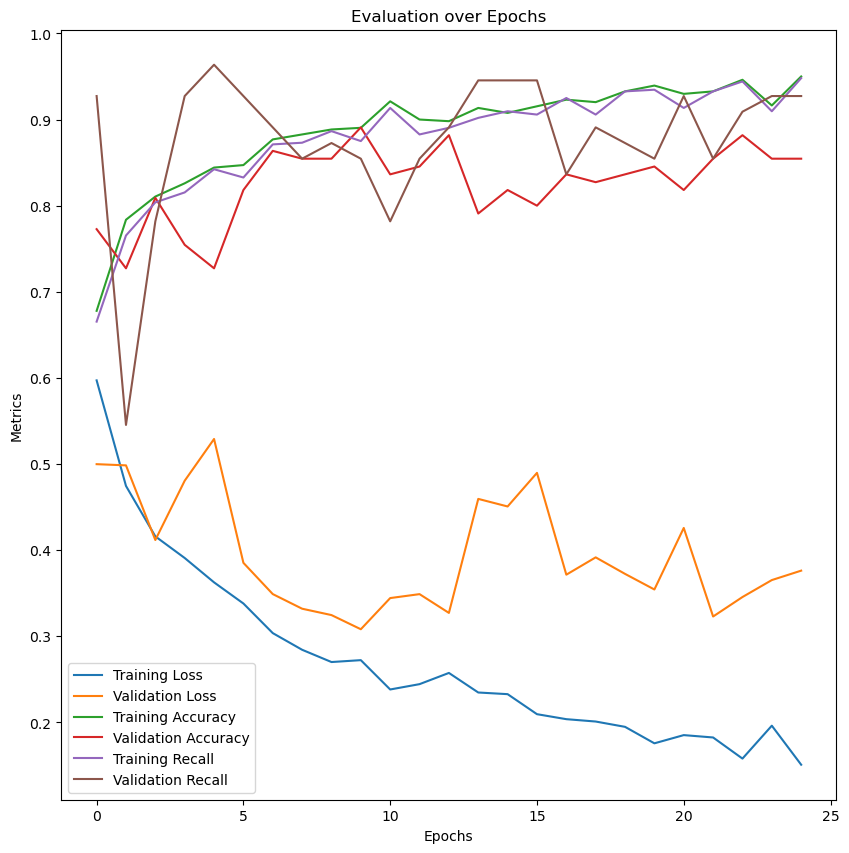

In [25]:
# plotting the training and validation metrics over epochs
plt.figure(figsize=(10,10))
plt.plot(history_trans_vgg16.history['loss'], label='Training Loss', )
plt.plot(history_trans_vgg16.history['val_loss'], label='Validation Loss')
plt.plot(history_trans_vgg16.history['accuracy'], label='Training Accuracy')
plt.plot(history_trans_vgg16.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history_trans_vgg16.history['recall_1'], label='Training Recall')
plt.plot(history_trans_vgg16.history['val_recall_1'], label='Validation Recall')
plt.title('Evaluation over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()

In [26]:
model.save('../assets/saved_models/vgg16_models/best_model')

INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models/best_model\assets


INFO:tensorflow:Assets written to: ../assets/saved_models/vgg16_models/best_model\assets


In [33]:
# feed the test dataset to the model to generate predictions
test_datagen = ImageDataGenerator(
    rescale=1./255 # This is a necessary preprocessing step
)
test_generator = test_datagen.flow_from_directory(
    '../data/test/',
    target_size=model_target_size,
    batch_size=model_batch_size,
    class_mode=None,
    shuffle=False
)

print(test_generator.class_indices)

Found 110 images belonging to 2 classes.
{'clean': 0, 'dirty': 1}


In [34]:
# make predictions
predictions = model.predict(test_generator, verbose=1)
predicted_class = (predictions > 0.5).astype(int)
class_labels = test_generator.classes
image_names = test_generator.filenames

# print image name and prediction
for image, pred_class in enumerate(predicted_class):
    print(f'Image {image_names[image]} predicted as class: {pred_class}')

4/4 [==============================] - 18s 3s/step
Image clean\0b80c8d6-b7ed-4d79-a706-998916e0a382.jpg predicted as class: [0]
Image clean\12858a3f-56ed-49e4-95eb-545ae1704614.jpg predicted as class: [0]
Image clean\12c943_3bc17c3f912841f4a7603e4f39510ebb~mv2.jpg predicted as class: [0]
Image clean\12c943_52556a070d844543b57583b7291c93a5~mv2.jpg predicted as class: [0]
Image clean\12c943_58584a79314748be87e4ca0e14376463~mv2.jpg predicted as class: [0]
Image clean\12c943_cd41237a10f2407b89f1966ac9b600f6~mv2.jpg predicted as class: [1]
Image clean\1f6e67e3-237a-4bb6-8350-44c1126bf3a3.jpg predicted as class: [0]
Image clean\2cc35a54-8d60-472a-a74f-984aec8f068b.jpg predicted as class: [0]
Image clean\41d7a1dc-aac8-4c75-9c62-bb0cfd9fe294.jpg predicted as class: [0]
Image clean\46485657_1983197591727493_4784383999109758976_n.jpg predicted as class: [0]
Image clean\465062812_8596809190366267_1476424721414631274_n.jpg predicted as class: [1]
Image clean\46516200_1983204038393515_5825976339336

Precision score: 0.57.
Recall score: 0.44.
F1 score: 0.49.


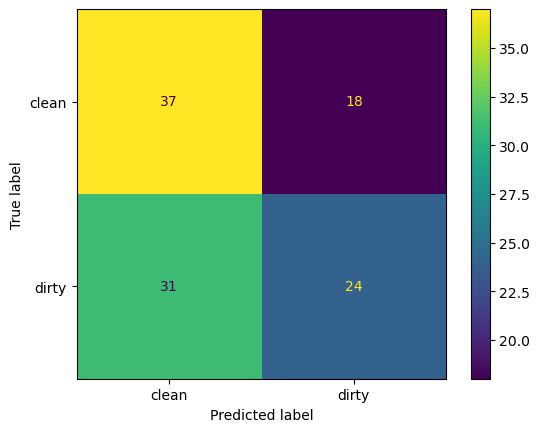

In [35]:
# evaluation metrics
precision = precision_score(class_labels, predicted_class)
recall = recall_score(class_labels, predicted_class)
f1_result = f1_score(class_labels, predicted_class)
confusing_matrix = confusion_matrix(class_labels, predicted_class)

print(f'Precision score: {round(precision, 2)}.')
print(f'Recall score: {round(recall, 2)}.')
print(f'F1 score: {round(f1_result, 2)}.')

cmd = ConfusionMatrixDisplay(confusion_matrix=confusing_matrix, display_labels=test_generator.class_indices)
cmd.plot();

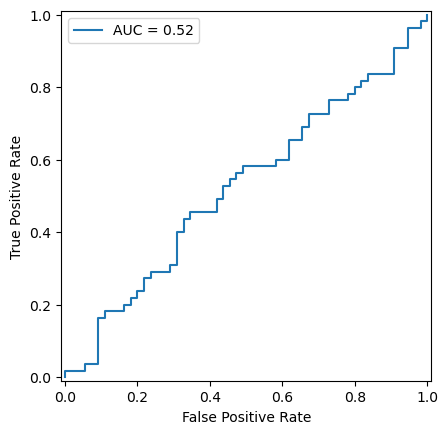

In [38]:
# Check the ROC Curve - will help us see how well the model is defining classes
fpr, tpr, thresholds = roc_curve(class_labels, predictions)
roc_auc = auc(fpr, tpr)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()
plt.legend()
plt.show;

In [39]:
# generate the roc_auc_score
roc_auc_score = round(roc_auc_score(class_labels, predictions), 4)
roc_auc_score

0.5233

In [40]:
# list of false negatives
false_negatives = []
print('False Negatives')
for image, pred_class in enumerate(predicted_class):
    if pred_class == 0:
        if pred_class != class_labels[image]:
            false_negatives.append(image_names[image])
            print(f'Image {image_names[image]} predicted class "clean" but labeled "dirty".')

False Negatives
Image dirty\12c943_01784894d7a94b78ad879c70922956c4~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\12c943_468c16c8337143a491c052f986f69fe4~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\12c943_b39fdc489ba944a8a567415f3928e108~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\12c943_c848c295e3d2464c96d2e64d900ce4c4~mv2.jpg predicted class "clean" but labeled "dirty".
Image dirty\269de922-5615-4ba0-9acf-1b585e892f6a.jpg predicted class "clean" but labeled "dirty".
Image dirty\46470628_1983209375059648_1082277994191388672_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\46492871_1983209448392974_3887692697124732928_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\46494600_1983204141726838_6445632630003073024_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\46508831_1983203755060210_6577736907675926528_n.jpg predicted class "clean" but labeled "dirty".
Image dirty\46521402_198320951